In [21]:
import matplotlib.pyplot as plt
from lmfit import Parameters
from lmfit import minimize, fit_report

In [22]:
import pyroll.core as pr
import pyroll.pillar_model
import pyroll.neutral_point_estimator
import pyroll.sparling_spreading
import pyroll.hensel_force_torque
import pyroll.freiberg_flow_stress
import pyroll.ring_model_thermal
from pyroll.freiberg_flow_stress import flow_stress

In [23]:
from in_profile import create_in_profile_for_finishing_train
from rolling_sequence import finishing_pass_design_1, finishing_pass_design_2, finishing_pass_design_3, finishing_pass_design_4
from utilities import *

In [24]:
pyroll.pillar_model.Config.PILLAR_COUNT = 30
pyroll.neutral_point_estimator.Config.ESTIMATOR = "EQUAL"
ROLL_SURFACE_TEMPERATURE = 50 + 273.15
DISK_ELEMENT_COUNT = 30

In [25]:
@pr.CoolingPipe.DiskElement.heat_transfer_coefficient
def heat_transfer_coefficient_model_moreales(self: pr.CoolingPipe.DiskElement):
    mean_surface_temperature = (self.in_profile.surface_temperature + self.out_profile.surface_temperature) / 2
    profile_surface_temperature_celsius = mean_surface_temperature - 273.15
    return 13950 + 5.12 * 1e6 / profile_surface_temperature_celsius

In [26]:
in_profile = create_in_profile_for_finishing_train(950 + 273.15)
in_profile.ring_temperatures = in_profile.ring_temperatures

In [27]:
rolling_train_rpd1 = finishing_pass_design_1(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
rolling_train_rpd2 = finishing_pass_design_2(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
rolling_train_rpd3 = finishing_pass_design_3(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
rolling_train_rpd4 = finishing_pass_design_4(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)

In [ ]:
rolling_train_rpd1.solve(in_profile)
rolling_train_rpd2.solve(in_profile)
rolling_train_rpd3.solve(in_profile)
rolling_train_rpd4.solve(in_profile)

Solution iteration of TwoRollPass '23-H' exceeded the maximum iteration count of 100. Continuing anyway.


In [9]:
sequences = [
    {
        "label": "RPD1",
        "sequence": rolling_train_rpd1
    },
    {
        "label": "RPD2",
        "sequence": rolling_train_rpd2
    },
    {
        "label": "RPD3",
        "sequence": rolling_train_rpd3
    },
    {
        "label": "RPD4",
        "sequence": rolling_train_rpd4
    }
]

In [10]:
def solve_total_wear_depths_as_contour_line(params):
    area_errors = []

    for entry in sequences:
        groove_label = entry["label"]
        sequence = entry["sequence"]
        roll_passes = sequence.roll_passes
        measurements = extract_wear_contours_from_measurement(groove_label)

        for measurement_id, labels, tonnages, measured_wear_contours in measurements:

            for roll_pass in roll_passes:
                for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                    if roll_pass.label == label:

                        wear_coefficient = get_wear_coefficient(roll_pass, params)
                        calculated_wear_contour = calculate_wear_contour(roll_pass, wear_coefficient, tonnage * 1000)
                        area_error = calculate_area_between_contours(calculated_wear_contour, measured_wear_contour)
                        area_errors.append(area_error)
                    else:
                        continue
    rms_error = root_mean_square_value(np.array(area_errors))
    print("RMS error: ", rms_error)
    return np.array(area_errors)


def solve_total_wear_depths_as_contour_line_4_pass_block(params):
    area_errors = []

    for entry in sequences:
        groove_label = entry["label"]
        sequence = entry["sequence"]
        roll_passes = sequence.roll_passes
        measurements = extract_wear_contours_from_measurement(groove_label)

        for measurement_id, labels, tonnages, measured_wear_contours in measurements:
            for roll_pass in roll_passes:
                for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                    if roll_pass.label == label and label in ["17-H", "18-V"]:

                        wear_coefficient = get_wear_coefficient(roll_pass, params)
                        calculated_wear_contour = calculate_wear_contour(roll_pass, wear_coefficient, tonnage * 1000)
                        area_error = calculate_area_between_contours(calculated_wear_contour, measured_wear_contour)
                        area_errors.append(area_error)
                    else:
                        continue
    rms_error = root_mean_square_value(np.array(area_errors))
    print("RMS error: ", rms_error)
    return np.array(area_errors)


def solve_total_wear_depths_as_contour_line_6_pass_block(params):
    area_errors = []

    for entry in sequences:
        groove_label = entry["label"]
        sequence = entry["sequence"]
        roll_passes = sequence.roll_passes
        measurements = extract_wear_contours_from_measurement(groove_label)

        for measurement_id, labels, tonnages, measured_wear_contours in measurements:
            for roll_pass in roll_passes:
                for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                    if roll_pass.label == label and label in ["21-H", "22-V", "23-H", "24-V"]:

                        wear_coefficient = get_wear_coefficient(roll_pass, params)
                        calculated_wear_contour = calculate_wear_contour(roll_pass, wear_coefficient, tonnage * 1000)
                        area_error = calculate_area_between_contours(calculated_wear_contour, measured_wear_contour)
                        area_errors.append(area_error)
                    else:
                        continue
    rms_error = root_mean_square_value(np.array(area_errors))
    print("RMS error: ", rms_error)
    return np.array(area_errors)


def solve_total_wear_depths_as_contour_line_csb_block(params):
    area_errors = []

    for entry in sequences:
        groove_label = entry["label"]
        sequence = entry["sequence"]
        roll_passes = sequence.roll_passes
        measurements = extract_wear_contours_from_measurement(groove_label)

        for measurement_id, labels, tonnages, measured_wear_contours in measurements:
            for roll_pass in roll_passes:
                for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                    if roll_pass.label == label and label in ["27-H", "28-V"]:

                        wear_coefficient = get_wear_coefficient(roll_pass, params)
                        calculated_wear_contour = calculate_wear_contour(roll_pass, wear_coefficient, tonnage * 1000)
                        area_error = calculate_area_between_contours(calculated_wear_contour, measured_wear_contour)
                        area_errors.append(area_error)
                    else:
                        continue
    rms_error = root_mean_square_value(np.array(area_errors))
    print("RMS error: ", rms_error)
    return np.array(area_errors)

In [11]:
params_constant_cobyla = Parameters()
params_constant_cobyla.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

params_4_pass_block_cobyla = Parameters()
params_4_pass_block_cobyla.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

params_6_pass_block_cobyla = Parameters()
params_6_pass_block_cobyla.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

params_csb_block_cobyla = Parameters()
params_csb_block_cobyla.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

In [12]:
result_constant_cobyla = minimize(
    solve_total_wear_depths_as_contour_line,
    params_constant_cobyla,
    nan_policy='omit',
    max_nfev=100,
    method="cobyla"
)

RMS error:  0.2696222267649576
RMS error:  642.5620683124073
RMS error:  597.1880559257773
RMS error:  152.34462002008195
RMS error:  48.84143290355993
RMS error:  7.4246574123384255
RMS error:  4.5852666201657755
RMS error:  0.0853024756644965
RMS error:  0.4868078221925422
RMS error:  0.007960911107696754
RMS error:  0.0001458343077710213
RMS error:  0.003952257372881602
RMS error:  0.00017110280940654007
RMS error:  0.0006152926836533513
RMS error:  3.179751912794925e-05
RMS error:  4.1252150767941e-06
RMS error:  7.840212027561388e-06
RMS error:  3.909708751355861e-06
RMS error:  3.909708751355861e-06
RMS error:  3.909708751355861e-06
RMS error:  5.0762171052133984e-05
RMS error:  7.840212027561388e-06


In [13]:
result_4_pass_block_cobyla = minimize(
    solve_total_wear_depths_as_contour_line_4_pass_block,
    params_4_pass_block_cobyla,
    nan_policy='omit',
    max_nfev=100,
    method="cobyla"
)

RMS error:  0.2933020538624633
RMS error:  698.9953269464319
RMS error:  649.6363246333111
RMS error:  165.7243444727094
RMS error:  53.13095051037287
RMS error:  8.07673093080779
RMS error:  4.987969560434718
RMS error:  0.09279435050038633
RMS error:  0.5295620569390743
RMS error:  0.008660235119475971
RMS error:  0.00015888890346689815
RMS error:  0.0042995215649113015
RMS error:  0.00018636251644091
RMS error:  0.0006695052968804029
RMS error:  3.524813101169142e-05
RMS error:  6.978613221949213e-06
RMS error:  1.02441869758395e-05
RMS error:  6.95943568369276e-06
RMS error:  6.95943568369276e-06
RMS error:  6.95943568369276e-06
RMS error:  5.569999539125539e-05
RMS error:  1.02441869758395e-05


In [14]:
result_6_pass_block_cobyla = minimize(
    solve_total_wear_depths_as_contour_line_6_pass_block,
    params_6_pass_block_cobyla,
    nan_policy='omit',
    max_nfev=100,
    method="cobyla"
)

RMS error:  0.303063260687361
RMS error:  722.2586445519288
RMS error:  671.2569214462883
RMS error:  171.2398290608408
RMS error:  54.89920560247483
RMS error:  8.34553303914187
RMS error:  5.153974361518989
RMS error:  0.09588244470452849
RMS error:  0.5471862513232817
RMS error:  0.008948253012638607
RMS error:  0.00016383657963263895
RMS error:  0.004442407684903789
RMS error:  0.00019224528258176762
RMS error:  0.000691553210980818
RMS error:  3.5473938446226494e-05
RMS error:  2.9129877418238117e-06
RMS error:  7.971591614283659e-06
RMS error:  2.4050828199086403e-06
RMS error:  2.4050828199086403e-06
RMS error:  2.4050828199086403e-06
RMS error:  5.687074393499953e-05
RMS error:  7.971591614283659e-06


In [15]:
result_csb_block_cobyla = minimize(
    solve_total_wear_depths_as_contour_line_csb_block,
    params_csb_block_cobyla,
    nan_policy='omit',
    max_nfev=100,
    method="cobyla"
)

RMS error:  0.12426940633396572
RMS error:  296.1584326294632
RMS error:  275.2454390689558
RMS error:  70.21600875851095
RMS error:  22.511136039393936
RMS error:  3.4220426666392636
RMS error:  2.113360488688993
RMS error:  0.03931598110814247
RMS error:  0.224370779781899
RMS error:  0.0036690641699168563
RMS error:  6.706508573819128e-05
RMS error:  0.0018214656097809787
RMS error:  7.871312045601414e-05
RMS error:  0.00028344816312328365
RMS error:  1.4450215545437028e-05
RMS error:  1.596968321259109e-06
RMS error:  3.256270309848503e-06
RMS error:  1.201791552342543e-06
RMS error:  8.906343212660826e-06
RMS error:  8.906343212660826e-06
RMS error:  8.906343212660826e-06
RMS error:  4.375919721317824e-05
RMS error:  1.596968321259109e-06


In [16]:
print(fit_report(result_csb_block_cobyla))

[[Fit Statistics]]
    # fitting method   = COBYLA
    # function evals   = 19
    # data points      = 16
    # variables        = 1
    chi-square         = 1.2692e-09
    reduced chi-square = 8.4611e-11
    Akaike info crit   = -370.119898
    Bayesian info crit = -369.347309
[[Variables]]
    wear_coefficient:  8.1723e-10 +/- 1.4021e-10 (17.16%) (init = 1e-05)


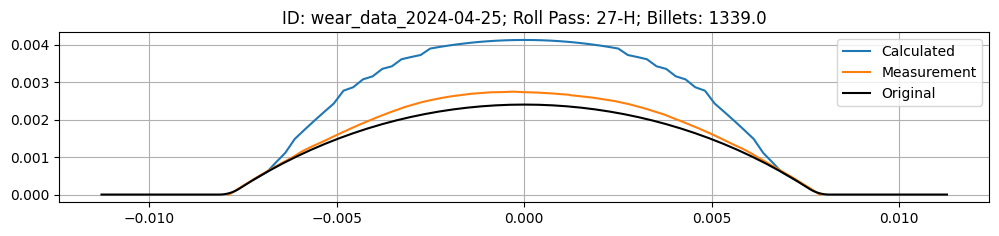

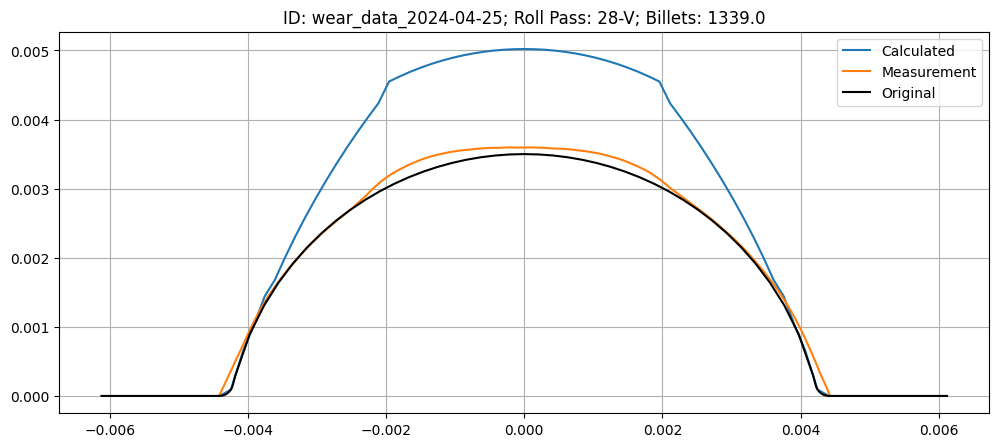

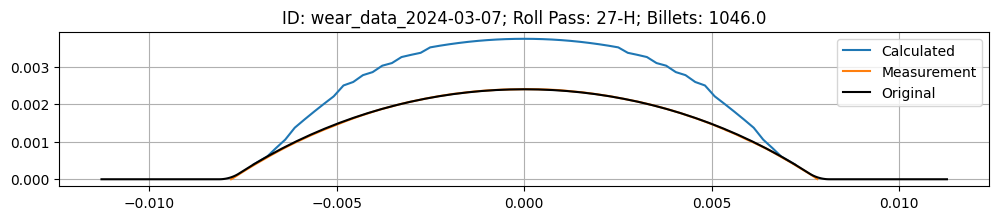

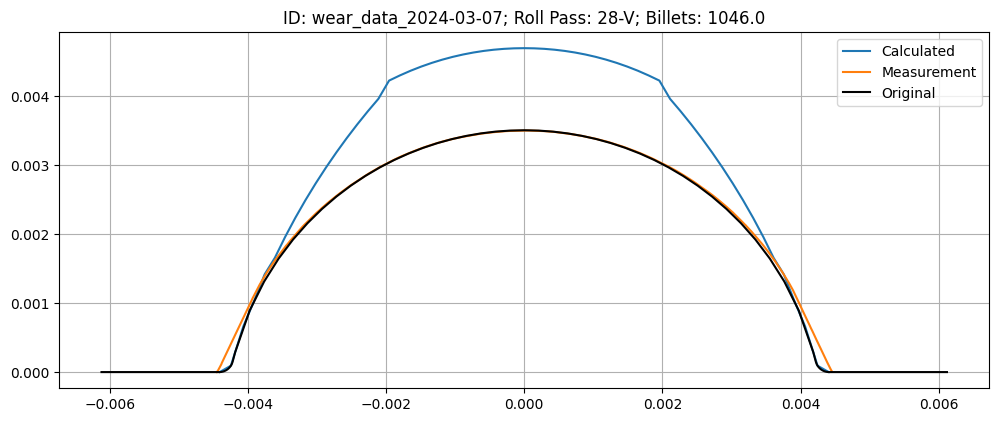

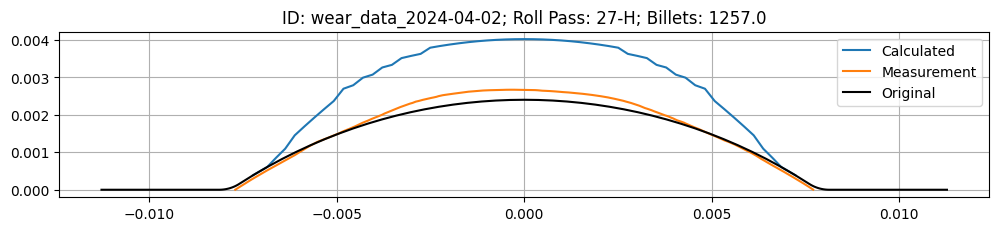

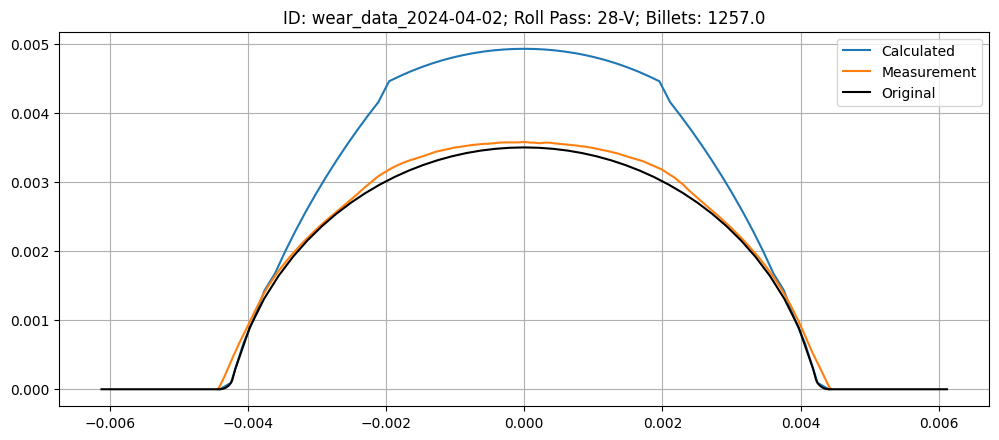

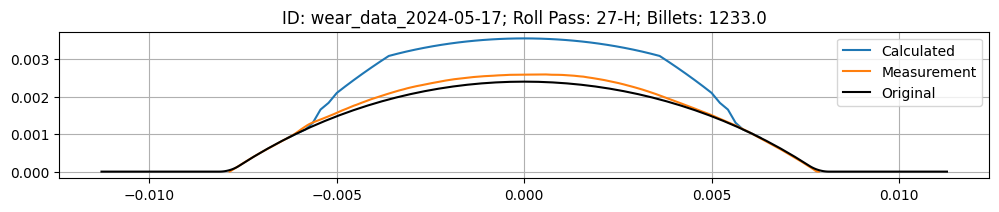

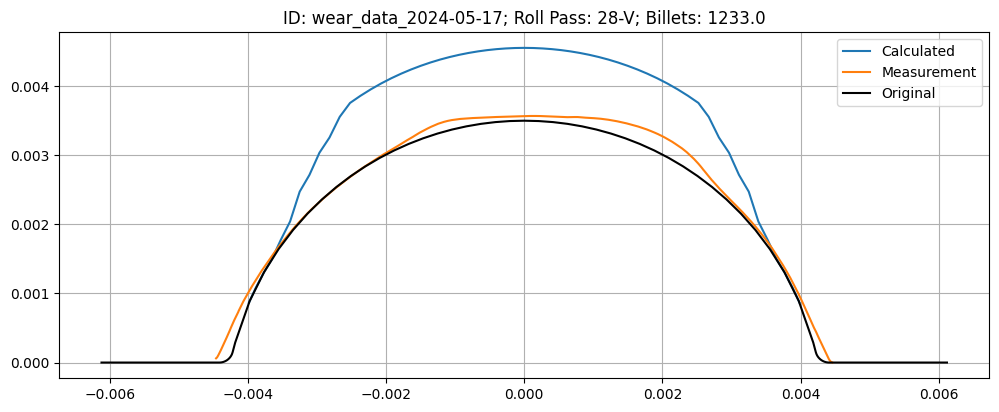

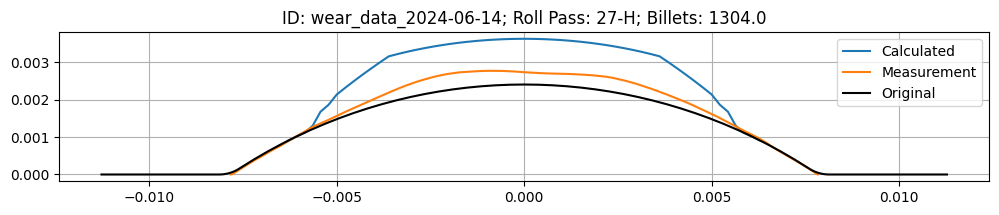

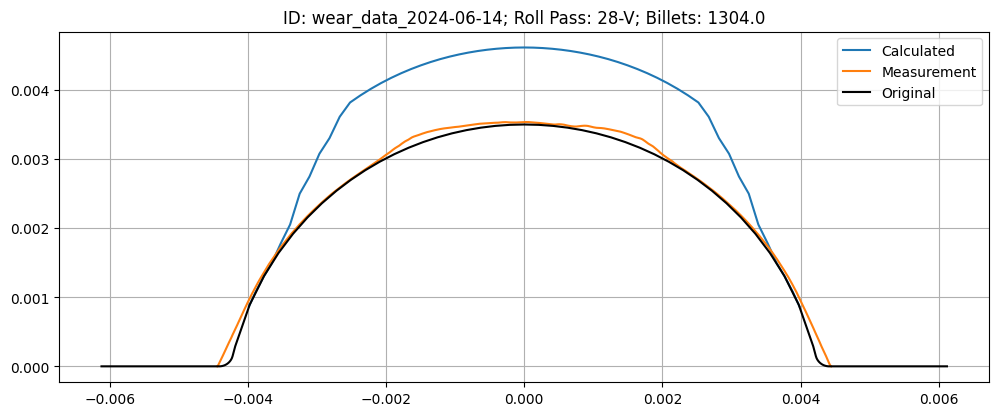

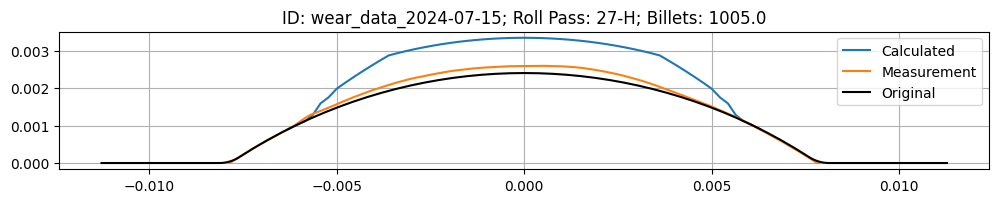

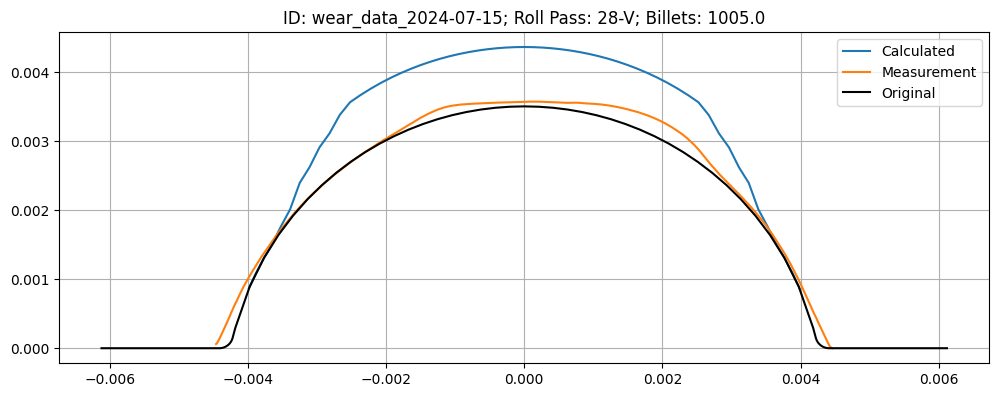

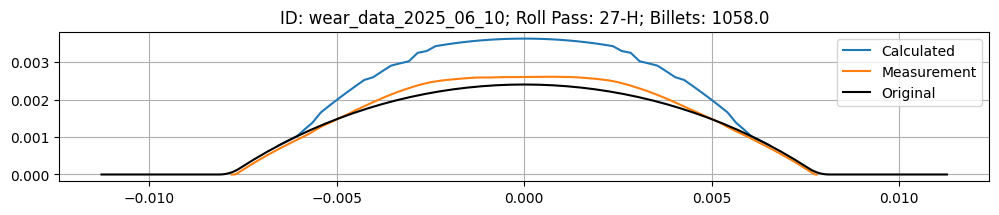

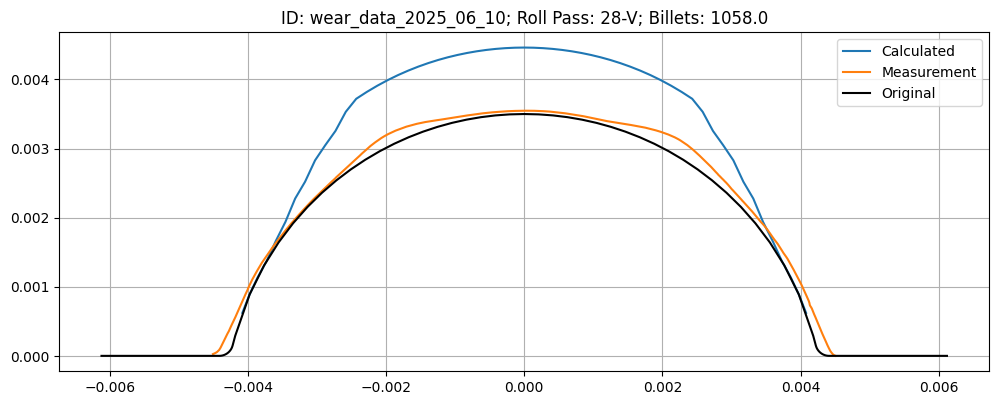

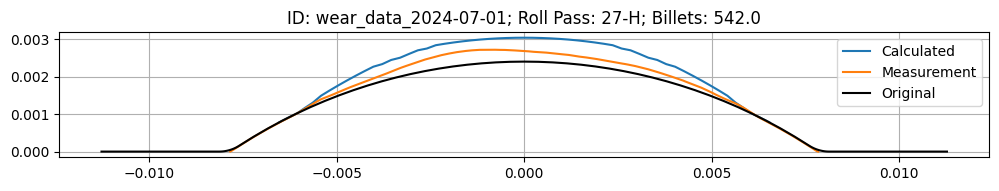

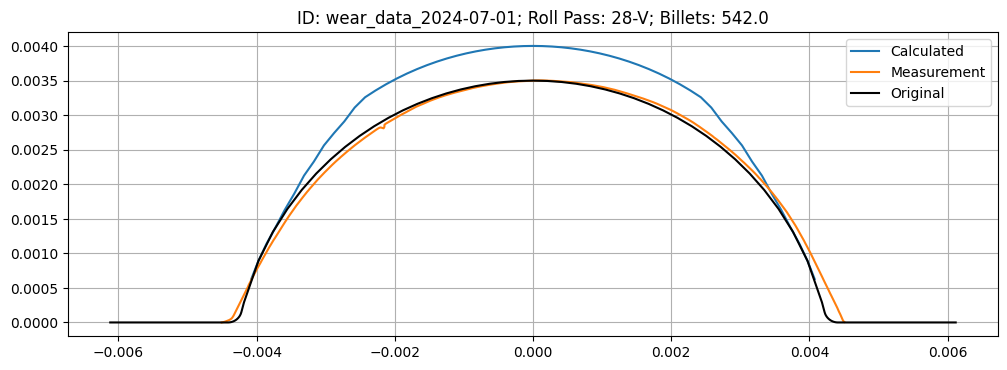

In [17]:
measured_wear_area = []
calculated_wear_area = []

measured_wear_area_4_pass = []
calculated_wear_area_4_pass = []

measured_wear_area_6_pass = []
calculated_wear_area_6_pass = []

measured_wear_area_csb = []
calculated_wear_area_csb = []

for entry in sequences:
    groove_label = entry["label"]
    sequence = entry["sequence"]
    roll_passes = sequence.roll_passes
    measurements = extract_wear_contours_from_measurement(groove_label)
    for measurement_id, labels, tonnages, measured_wear_contours in measurements:
        for roll_pass in roll_passes:
            for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                if roll_pass.label == label:
                    measured_wear_area.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))
                    calculated_wear_contour = calculate_wear_contour(roll_pass, result_constant_cobyla.params['wear_coefficient'].value, tonnage * 1000)
                    calculated_wear_area.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                    if roll_pass.label in ["17-H", "18-V"]:
                        calculated_wear_contour = calculate_wear_contour(roll_pass, result_4_pass_block_cobyla.params['wear_coefficient'].value, tonnage * 1000)
                        calculated_wear_area_4_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                        measured_wear_area_4_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))
                    elif roll_pass.label in ["21-H", "22-V", "23-H", "24-V"]:
                         calculated_wear_contour = calculate_wear_contour(roll_pass, result_6_pass_block_cobyla.params['wear_coefficient'].value, tonnage * 1000)
                         calculated_wear_area_6_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                         measured_wear_area_6_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))
                         fig, ax = plt.subplots(figsize=(12, 8))
                         ax.grid()
                         title_string = "ID: " + measurement_id + "; Roll Pass: " + label + "; Billets: " + str(
                            number_of_billets)
                         ax.set_title(title_string)
                         ax.set_aspect('equal')
                         ax.plot(*calculated_wear_contour.xy, label="Calculated")
                         ax.plot(*measured_wear_contour.xy, label="Measurement")
                         ax.plot(*roll_pass.roll.contour_line.xy, label="Original", color='black')
                         ax.legend()
                    elif roll_pass.label in ["27-H", "28-V"]:
                         calculated_wear_contour = calculate_wear_contour(roll_pass, result_csb_block_cobyla.params['wear_coefficient'].value, tonnage * 1000)
                         calculated_wear_area_csb.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                         measured_wear_area_csb.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))
                         number_of_billets = np.round(tonnage * 1000 / 2400)


In [18]:
len(measured_wear_area)

69

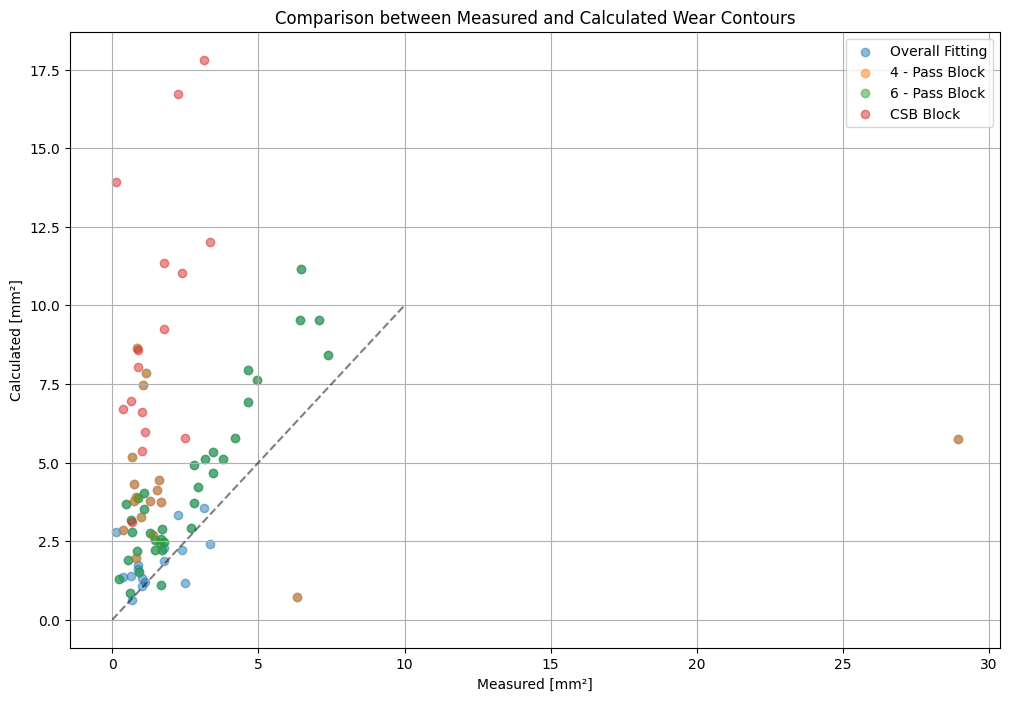

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(np.array(measured_wear_area) * 1e6, np.array(calculated_wear_area) * 1e6, color='C0', alpha=0.5, label="Overall Fitting")
ax.scatter(np.array(measured_wear_area_4_pass) * 1e6, np.array(calculated_wear_area_4_pass) * 1e6, color='C1', alpha=0.5, label="4 - Pass Block")
ax.scatter(np.array(measured_wear_area_6_pass) * 1e6, np.array(calculated_wear_area_6_pass) * 1e6, color='C2', alpha=0.5, label="6 - Pass Block")
ax.scatter(np.array(measured_wear_area_csb) * 1e6, np.array(calculated_wear_area_csb) * 1e6, color='C3', alpha=0.5, label="CSB Block")
ax.plot(np.linspace(0, 10, 10), np.linspace(0, 10, 10), alpha=0.5, ls='--', color='black')
ax.grid()
ax.set_title("Comparison between Measured and Calculated Wear Contours")
ax.set_ylabel("Calculated [mm²]")
ax.set_xlabel("Measured [mm²]")

handels, labels = ax.get_legend_handles_labels()
unique_legends = dict(zip(labels, handels))
ax.legend(
    unique_legends.values(), unique_legends.keys(),
    loc="upper right"
)


In [20]:

# params_linear_function_cobyla = Parameters()
# params_linear_function_cobyla.add('base_wear_coefficient', value=1e-5, min=1e-10, max=1e-1, vary=True)
# params_linear_function_cobyla.add('roll_gap_ratio_coefficient', value=1e-5, min=1e-10, max=1e-1, vary=True)
#
# params_cubic_function_cobyla = Parameters()
# params_cubic_function_cobyla.add('base_wear_coefficient', value=1e-5, min=1e-10, max=1e-1, vary=True)
# params_cubic_function_cobyla.add('roll_gap_ratio_coefficient', value=1e-5, min=1e-10, max=1e-1, vary=True)
# params_cubic_function_cobyla.add('speed_ratio_coefficient', value=1e-5, min=1e-10, max=1e-1, vary=True)
#
#
#
# result_linear_function_cobyla = minimize(
#     solve_total_wear_depths_as_contour_line,
#     params_linear_function_cobyla,
#     nan_policy='omit',
#     max_nfev=100,
#     method="cobyla"
# )
#
# result_cubic_function_cobyla = minimize(
#     solve_total_wear_depths_as_contour_line,
#     params_cubic_function_cobyla,
#     nan_policy='omit',
#     max_nfev=100,
#     method="cobyla"
# )
